# Preparation
Before we start, it is required to have the software as listed below be installed.
- Python 3.5 and above
- A browser with ability to prop console.

## Running on Colabotory
Since google colab treats the python environment seperately, it is required for Google Drive to be mounted onto the filesystem that it is in. We need this because we store the links in JSON format and needed it to be carried around

Run the following codes and follow the instructions to mount google drive into the filesystem. *(You need to run this only once in a notebook per runtime)*



In [143]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

gpg: keybox '/tmp/tmpcvfkojse/pubring.gpg' created
gpg: /tmp/tmpcvfkojse/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [145]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


You can check if it is properly mounted.

In [146]:
!ls drive

a2_data_ana				      scalable
adb-setup-1.3.exe			      scalable-create.html
ai2.html				      scan.pdf
ai3					      TAN ZHONG.jpg
ai.xml					      this.folder()
Apps					      UH8Y9H-KUL-HKG.pdf
CCST poster pres'			      Untitled document.odt
Colab Notebooks				      Untitled document.odt (2c2ecd40)
!consent form - Second Life Research.doc.odt  Untitled document.odt (41fedfe1)
Cultural Expansion.pptx			      Untitled document.odt (78d9191f)
erd_malnutrition			      Untitled document.odt (8f42b8bc)
FIND  ATTACHED.odt			      Untitled document.odt (9a2f2870)
hku-course.ods				      Untitled document.odt (b93477c9)
IMG_20140225_145804.jpg			      Untitled document.odt (d34cb20a)
Itinerary: Kuching			      Untitled document.odt (f09648ae)
MediaPlayer.zip				      Untitled document.odt (f194ba49)
modern-javascript.pdf			      web-flow
Mom'snag				      WLH 2014-15 Round I Result.pdf
Mom'snag (6f0c38e2)			      wordcnt-p1 (82b1765c).c
My Course History.htm			      wordcnt-p1.c
PBL 3.odt			

## Working directory setting
If you are running this notebook on your own computer, you should use empty string. If you are running this notebook on Google Colaboratory, you should edit the following part to `drive/PATH_TO_YOUR_APP_FROM_GDRIVE_ROOT`


In [0]:
# current working directory
# pwd = '' # for local
pwd = 'drive/a2_data_ana/' # our case, change the directory to the correct path

# Obtaining Links for Data Collection
Using the link suggested by class, we had decided to use [EdgeProp](https://www.edgeprop.my)'s data that are available on their website.

Before we start, it is required to obtain the links to the pages that contains data that we need. A simple JavaScript is written to assist the job.

Going to one of the transaction search on EdgeProp (such as [this](https://www.edgeprop.my/transaction/kuala-lumpur?start=2012-01-01&end=2018-07-31&price=0)), and open the console menu.

![Opens console menu. Use img/ss1.png if no internet or broken.](http://tzhongyan.com/img/ss1.png)

We can ignore the warnings shown. Copy the following JavaScript into the console and hit enter.
```js
let t = document.getElementsByClassName('transaction-row');
let ar = [];

for (let i=1; i<t.length; i++) {
    let k = t[i];
    let name = k.childNodes[1].childNodes[1].childNodes[1].firstChild.data;
    let url = k.childNodes[3].childNodes[1].childNodes[1].href;
    ar.push({'neighbourhood':name.trim(), 'url': url});
}
```

![Copy JavaScript and hit Enter. Use img/ss2.png if broken](http://tzhongyan.com/img/ss2.png)

Since the JavaScript buffers the data in `ar` object, we should type in `ar` into the console and hit Enter.
![Type ar and hit enter. Use img/ss1.png if no internet or broken.](http://tzhongyan.com/img/ss3.png)


Right click the object and copy the object.
![Right click to copy the object. Use img/ss1.png if no internet or broken.](http://tzhongyan.com/img/ss4.png)

Open your favourite text editor, and paste using CTRL + V or COMMAND + V. Save the file with `lists.json` or any name of your liking. The file will be used for next step.

# Data Collection
For this assignment, as we are required to do prediction within Klang Valley, data from Kuala Lumpur and Selangor are required to be obtained.

For this case, we have done the link obtains for both Kuala Lumpur and Selangor, and saved the json objects in `list` folder as `kl.json` and `selangor.json` respectively. So the directory should be something like this:
```
 /
 |- list/
    |- kl.json
    |- selangor.json
     
 |- img/
    |- ss1.png
    |- ss2.png
    |- ss3.ong
    |- ss4.pmg
    
 |- a2.ipynb
 
 |- output/ (empty folder now)
```

Next, we will need to crawl the data from the URLs that are stated in the JSON objects.

## Imports and Login Sessions

In [0]:
from bs4 import BeautifulSoup
import requests

import json
import pandas as pd

import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

import warnings
warnings.filterwarnings("ignore")

Since EdgeProp requires login to show all the data, we will need to handle login session. 

**Change the below email/password authenticate in EdgeProp.** Failling to do so will only get 10 data for each neighbourhood or township.

In [149]:
email = ""
password = ""


session_requests = requests.session()

""" LOGIN AND GET SESSION """
login_url = "https://www.edgeprop.my/user/login"
# Get login csrf token
login_page = session_requests.get(login_url)
soup = BeautifulSoup(login_page.text, 'html.parser')
authenticity_token = soup.find("input", { "name": "form_build_id" } )["value"]
payload = { "name": email, "pass": password, "form_build_id": authenticity_token, "form_id": "user_login" }
# Perform login
result = session_requests.post(login_url, data = payload, headers = dict(referer = login_url))
""" END LOGIN AND GET SESSION """

' END LOGIN AND GET SESSION '

Define a scrapper function that obtain data from the url upon calling, and return a dataframe with its relative data.

In [0]:
def scrap(url_k):
	page = session_requests.get(url_k, headers = dict(referer = 'https://www.edgeprop.my/transaction/selangor?start=2012-01-01&end=2018-06-31&price=0'))
	soup = BeautifulSoup(page.text, 'html.parser')

	# Extract result
	date_list = soup.find_all("div", class_="transaction-item transaction-date")
	price_list = soup.find_all("div", class_="transaction-item transaction-price")
	type_list = soup.find_all("div", class_="transaction-item transaction-type2")
	sf_list = soup.find_all("div", class_="transaction-item transaction-sqft")
	addr_list = soup.find_all("div", class_="transaction-item transaction-address")

	d = {
		'date': [date.get_text() for date in date_list],
		'price': [locale.atoi(price.get_text()) for price in price_list],
		'house_type': [hse.get_text() for hse in type_list],
		'area_sf': [locale.atoi(area.get_text()) for area in sf_list],
		'addr': [addr.get_text() for addr in addr_list]
	}

	return pd.DataFrame(data=d)

## Crawler
### Selangor Data
Open the json file that you want scrawl, we will be running selangor first:

In [0]:

# load links from json
with open(pwd + 'list/selangor.json') as f:
    data = json.load(f)

Obtaining the URL list, getting the area name from url, and remove the links of areas that are not in klang valley.

In [152]:
# spliting area using the url given
url_list = {
    'area': [d['url'].split('/')[5] for d in data],
    'url': [d['url'] for d in data],
    'neighbourhood': [d['neighbourhood'] for d in data]
}
df_url = pd.DataFrame(data=url_list)

# remove regions listen but not in klang valley
not_in_klang_valley = ['tanjong-sepat', 'tanjong-karang', 'batang-berjuntai', 'jenjarom'
					, 'kerling', 'sepang', 'semenyih', 'batang-kali', 'banting'
					, 'pulau-indah-(pulau-lumut)', 'sungai-besar', 'telok-panglima-garang'	
					, 'serendah', 'rasa', 'kuala-selangor', 'sabak-bernam', 'batu-arang'
					, 'beranang', 'jeram', 'kuala-kubu-baru', 'kuala-selangor', 'kuang'
					, 'sekinchan', 'sungai-pelek']
df_url = df_url[~df_url['area'].isin(not_in_klang_valley)]

df_url.head()

,area,neighbourhood,url
0,klang,Taman Sentosa,https://www.edgeprop.my/transaction/selangor/k...
1,hulu-selangor,Bukit Sentosa,https://www.edgeprop.my/transaction/selangor/h...
2,hulu-selangor,Bandar Bukit Beruntung,https://www.edgeprop.my/transaction/selangor/h...
3,bangi,Bandar Bukit Mahkota Bangi,https://www.edgeprop.my/transaction/selangor/b...
4,cheras-south,Bandar Mahkota Cheras,https://www.edgeprop.my/transaction/selangor/c...


Obtaining the data from URL listed above one by one. 
** *Note: this might take a while, easily 30 mins and beyond**

In [153]:
df = pd.DataFrame(data=[])

# scraping for each url
for index, row in df_url.iterrows():
	df2=scrap(row['url'])
	df2['area'] = row['area']
	df2['neighbourhood'] = row['neighbourhood']
	print(row['area'], ": ", len(df2.index))
	df = df.append(df2)

print('============================================')
print('total length: ', len(df.index))

klang :  10
hulu-selangor :  10
hulu-selangor :  10
bangi :  10
cheras-south :  10
bandar-puncak-alam :  10
denai-alam :  10
bandar-saujana-putra :  10
rawang :  10
kepong :  10
shah-alam :  10
bandar-botanic_bandar-bukit-tinggi :  10
damansara-perdana :  10
shah-alam :  10
ulu-kelang :  10
bandar-botanic_bandar-bukit-tinggi :  10
puchong-south :  10
puncak-jalil :  10
puchong-south :  10
shah-alam :  10
gombak :  10
kota-kemuning :  10
shah-alam :  10
bukit-jelutong :  10
rawang :  10
klang :  10
bandar-sunway :  10
bandar-damai-perdana :  10
puchong :  10
shah-alam :  10
klang :  10
bandar-sunway :  10
bandar-country-homes :  10
klang :  10
shah-alam :  10
sungai-buloh :  10
pandan-indah :  10
klang :  10
kajang :  10
hulu-selangor :  10
ampang :  10
pandan-jaya :  10
seri-kembangan :  10
shah-alam :  10
ampang :  10
hulu-selangor :  10
shah-alam :  10
kajang :  10
rawang :  10
bandar-botanic_bandar-bukit-tinggi :  10
puchong :  10
pandan-indah :  10
pandan-perdana :  10
selayang :  

puchong :  10
kajang :  10
damansara-damai :  10
klang :  10
bandar-sunway :  10
bukit-rahman-putra :  10
puchong :  10
subang-bestari :  10
klang :  10
rawang :  10
glenmarie :  10
ss2 :  10
ara-damansara :  10
batu-caves :  10
petaling-jaya :  10
damansara-damai :  10
bandar-puncak-alam :  10
bandar-sri-damansara :  10
bangi :  10
subang-jaya :  10
bandar-sungai-long :  10
bandar-sungai-long :  10
batu-9th-cheras :  10
damansara-damai :  10
shah-alam :  10
keramat :  10
tropicana :  10
usj :  10
bandar-kinrara-puchong :  10
usj :  10
bandar-puteri-puchong :  10
shah-alam :  10
seri-kembangan :  10
bandar-puteri-puchong :  10
klang :  10
shah-alam :  10
puchong :  10
batu-caves :  10
bangi :  10
puchong :  10
puchong :  10
selayang :  10
bandar-kinrara-puchong :  10
cheras :  10
kajang :  10
pandan-perdana :  0
shah-alam :  10
puchong-south :  10
puchong :  10
kajang :  10
bandar-puncak-alam :  10
bandar-kinrara-puchong :  10
pandan-indah :  10
ulu-kelang :  10
kajang :  10
kelana-jay

shah-alam :  10
bandar-kinrara-puchong :  10
puchong-south :  10
petaling-jaya :  10
cheras-south :  10
setia-alam_alam-nusantara :  10
bukit-subang :  10
kelana-jaya :  10
puchong :  10
petaling-jaya :  10
pandan-jaya :  10
klang :  10
bandar-country-homes :  10
seri-kembangan :  10
ara-damansara :  10
bandar-kinrara-puchong :  10
puchong-south :  10
damansara-damai :  10
batu-caves :  10
ampang :  10
seri-kembangan :  10
ampang :  10
kajang :  10
usj :  10
bandar-kinrara-puchong :  10
seri-kembangan :  10
taman-ttdi-jaya :  10
damansara-perdana :  10
damansara-damai :  10
subang-jaya :  10
bandar-botanic_bandar-bukit-tinggi :  10
rawang :  10
seri-kembangan :  10
petaling-jaya :  10
bangi :  10
port-klang :  10
bangi :  10
puchong :  10
setia-alam_alam-nusantara :  10
bandar-botanic_bandar-bukit-tinggi :  10
selayang :  10
subang-bestari :  10
shah-alam :  10
shah-alam :  10
seri-kembangan :  10
puchong-south :  10
sungai-buloh :  10
bandar-puteri-puchong :  10
seri-kembangan :  10
p

bandar-sri-damansara :  10
ara-damansara :  10
sungai-buloh :  10
cheras :  10
sungai-buloh :  10
port-klang :  10
subang-jaya :  10
rawang :  10
putra-heights :  10
bandar-sungai-long :  10
putrajaya :  10
petaling-jaya :  10
tropicana :  10
ampang :  10
klang :  10
subang :  10
ampang :  10
ampang :  10
shah-alam :  10
dengkil :  10
seri-kembangan :  10
bandar-country-homes :  10
damansara-utama :  10
usj :  10
petaling-jaya :  10
damansara-damai :  10
port-klang :  10
petaling-jaya :  10
usj :  10
mutiara-damansara :  10
pandan-indah :  10
damansara-damai :  10
setia-alam_alam-nusantara :  10
batu-caves :  10
kajang :  10
puchong-south :  10
klang :  10
kepong :  10
shah-alam :  10
keramat :  10
seri-kembangan :  10
damansara-perdana :  10
setia-alam_alam-nusantara :  10
klang :  10
kota-damansara :  10
batu-caves :  10
puchong-south :  10
usj :  10
shah-alam :  10
klang :  10
shah-alam :  10
puchong :  10
puchong :  10
putrajaya :  10
shah-alam :  10
puchong-south :  10
klang :  10

petaling-jaya :  10
seri-kembangan :  10
usj :  10
kelana-jaya :  10
cyberjaya :  10
petaling-jaya :  10
kota-damansara :  10
usj :  10
bandar-kinrara-puchong :  10
kajang :  10
kota-damansara :  10
kajang :  10
bandar-sungai-long :  10
batu-9th-cheras :  10
kayu-ara :  10
ampang :  10
usj :  10
cyberjaya :  10
kajang :  10
puchong :  10
selayang :  10
setia-alam_alam-nusantara :  10
cheras-south :  10
klang :  10
usj :  10
batu-9th-cheras :  10
bandar-sungai-long :  10
bandar-botanic_bandar-bukit-tinggi :  10
kajang :  10
shah-alam :  10
seri-kembangan :  10
hulu-selangor :  10
bangi :  10
kajang :  10
gombak :  10
klang :  10
petaling-jaya :  10
subang-jaya :  10
bandar-sunway :  10
bandar-kinrara-puchong :  10
kapar :  10
ampang :  10
kepong :  10
klang :  10
damansara-damai :  10
saujana :  10
cheras :  10
cheras :  10
dengkil :  10
bandar-sunway :  10
kepong :  10
keramat :  10
hulu-langat :  10
rawang :  10
bandar-country-homes :  10
setia-alam_alam-nusantara :  10
puchong :  10


kajang :  10
puchong :  10
ampang :  10
bandar-puncak-alam :  10
puchong :  10
kepong :  10
port-klang :  10
hulu-selangor :  10
bangi :  10
setia-alam_alam-nusantara :  10
sierramas :  10
cheras :  10
setia-alam_alam-nusantara :  10
klang :  10
usj :  10
usj :  10
cheras :  10
klang :  10
kelana-jaya :  10
petaling-jaya :  10
damansara-damai :  10
puchong :  10
cheras-south :  10
klang :  10
setia-alam_alam-nusantara :  10
bandar-sri-damansara :  10
port-klang :  10
setia-alam_alam-nusantara :  10
ampang :  10
ampang :  10
puchong :  10
rawang :  10
bandar-puteri-puchong- :  10
bandar-country-homes :  10
shah-alam :  10
damansara-perdana :  10
port-klang :  10
bandar-utama :  10
subang :  10
klang :  10
hulu-langat :  10
serdang :  10
klang :  10
batu-caves :  10
dengkil :  10
ampang :  10
puchong :  10
kajang :  10
bandar-country-homes :  10
kajang :  10
shah-alam :  10
ampang :  10
shah-alam :  10
kota-kemuning :  10
bandar-utama :  10
kepong :  10
kajang :  10
rawang :  10
subang-j

seri-kembangan :  10
kapar :  10
rawang :  10
kelana-jaya :  10
cyberjaya :  10
puchong-south :  10
sungai-buloh :  10
shah-alam :  10
ampang :  10
kota-kemuning :  10
bandar-sunway :  10
bangi :  10
keramat :  10
shah-alam :  10
subang :  10
klang :  10
ulu-kelang :  10
cheras-south :  10
klang :  10
batu-9th-cheras :  10
puchong-south :  10
cheras :  10
bandar-kinrara-puchong :  10
kajang :  10
usj :  10
klang :  10
kelana-jaya :  10
bandar-sungai-long :  10
subang :  10
petaling-jaya :  10
sungai-buloh :  10
pandan-perdana :  10
subang :  10
bangi :  10
setia-alam_alam-nusantara :  10
bandar-country-homes :  10
cheras-south :  10
petaling-jaya :  10
kajang :  10
kapar :  10
klang :  10
subang-jaya :  10
shah-alam :  10
cyberjaya :  10
cheras-south :  10
klang :  10
seri-kembangan :  10
ampang :  10
setia-alam_alam-nusantara :  10
petaling-jaya :  10
bandar-kinrara-puchong :  10
ampang :  10
batu-caves :  10
bandar-sri-damansara :  10
shah-alam :  10
setia-alam_alam-nusantara :  10
k

bandar-puteri-puchong :  10
port-klang :  10
shah-alam :  10
shah-alam :  10
bandar-saujana-putra :  10
puchong-south :  10
kelana-jaya :  10
klang :  10
ampang :  10
shah-alam :  10
klang :  10
setia-alam_alam-nusantara :  10
kajang :  10
rawang :  10
bangi :  10
ara-damansara :  10
puchong :  10
bandar-sunway :  10
kajang :  10
klang :  10
puchong-south :  10
kajang :  10
hulu-selangor :  10
shah-alam :  10
bangi :  10
kajang :  10
kajang :  10
puchong-south :  10
kajang :  10
mutiara-damansara :  10
pandan-perdana :  10
kapar :  10
tropicana :  10
kajang :  10
ara-damansara :  10
subang-jaya :  10
klang :  10
petaling-jaya :  10
rawang :  10
seri-kembangan :  10
subang :  10
kota-damansara :  10
petaling-jaya :  10
rawang :  10
kota-damansara :  10
bandar-sunway :  10
bandar-sri-damansara :  10
ampang :  10
kapar :  10
seri-kembangan :  10
puchong :  10
kelana-jaya :  10
seri-kembangan :  10
shah-alam :  10
subang-jaya :  10
bandar-country-homes :  10
selayang :  10
kelana-jaya :  1

cheras-south :  10
bandar-sungai-long :  10
kota-damansara :  10
kajang :  10
seri-kembangan :  10
kajang :  10
bangi :  10
ampang :  10
cyberjaya :  10
ampang :  10
port-klang :  10
puchong-south :  10
klang :  10
batu-9th-cheras :  10
shah-alam :  10
batu-9th-cheras :  10
subang :  10
kepong :  10
kajang :  10
kota-damansara :  10
bandar-sunway :  10
puchong-south :  10
seri-kembangan :  10
ampang :  10
port-klang :  10
bandar-puteri-puchong :  10
bangi :  10
bangi :  10
cheras :  10
klang :  10
klang :  10
port-klang :  10
dengkil :  10
shah-alam :  10
rawang :  10
kajang :  10
ampang :  10
batu-caves :  10
petaling-jaya :  10
keramat :  10
ampang :  10
bandar-country-homes :  10
batu-9th-cheras :  10
cheras-south :  10
kajang :  10
cheras-south :  10
shah-alam :  10
shah-alam :  10
bandar-kinrara-puchong :  10
taman-ttdi-jaya :  10
kajang :  10
bandar-puteri-puchong- :  10
taman-melawati :  10
ampang :  10
port-klang :  10
shah-alam :  10
shah-alam :  10
bangi :  10
klang :  10
ban

bukit-subang :  10
bangi :  10
puchong :  10
kota-damansara :  10
batu-9th-cheras :  10
ampang :  10
kelana-jaya :  10
subang :  10
seri-kembangan :  10
ampang :  10
sunway-damansara :  10
petaling-jaya :  10
kajang :  10
bukit-subang :  10
seri-kembangan :  10
klang :  10
shah-alam :  10
port-klang :  10
petaling-jaya :  10
ampang :  10
rawang :  10
bandar-kinrara-puchong :  10
ampang :  10
petaling-jaya :  10
bandar-kinrara-puchong :  10
kepong :  10
klang :  10
shah-alam :  10
bandar-sungai-long :  10
rawang :  10
seri-kembangan :  10
bangi :  10
sungai-buloh :  10
keramat :  10
bandar-bukit-raja :  10
rawang :  10
usj :  10
seri-kembangan :  10
ampang :  10
puchong :  10
bandar-sunway :  10
klang :  10
klang :  10
bandar-puteri-puchong :  10
puchong :  10
selayang :  10
shah-alam :  10
klang :  10
shah-alam :  10
kota-damansara :  10
kota-kemuning :  10
bandar-sunway :  10
bandar-puteri-puchong :  10
setia-alam_alam-nusantara :  10
ampang :  10
puchong :  10
kota-damansara :  10
ba

seri-kembangan :  10
subang-jaya :  10
klang :  10
puchong :  10
batu-caves :  10
batu-caves :  10
batu-9th-cheras :  10
ampang :  10
kelana-jaya :  10
damansara-damai :  10
bandar-saujana-putra :  10
taman-melawati :  10
bukit-jelutong :  10
petaling-jaya :  10
shah-alam :  10
bangi :  10
ampang :  10
selayang :  10
ara-damansara :  10
klang :  10
bandar-kinrara-puchong :  10
bandar-puteri-puchong :  10
bandar-sri-damansara :  10
batu-caves :  10
ulu-kelang :  10
bandar-country-homes :  10
klang :  10
batu-9th-cheras :  10
kajang :  10
setia-alam_alam-nusantara :  10
ulu-kelang :  10
kajang :  10
seri-kembangan :  10
bukit-subang :  10
usj :  10
puchong :  10
bandar-sri-damansara :  10
puchong-south :  10
puchong :  10
usj :  10
cheras-south :  10
petaling-jaya :  10
bandar-damai-perdana :  10
bandar-sungai-long :  10
hulu-selangor :  10
ulu-kelang :  10
batu-caves :  10
bandar-utama :  10
taman-melawati :  10
bandar-kinrara-puchong :  10
shah-alam :  10
bandar-sunway :  10
bandar-kin

bandar-sunway :  10
kota-damansara :  10
puchong-south :  10
ampang :  10
petaling-jaya :  10
bandar-utama :  10
seri-kembangan :  10
puchong :  10
klang :  10
klang :  10
kajang :  10
subang :  10
tropicana :  10
cheras :  10
gombak :  10
petaling-jaya :  10
sungai-buloh :  10
kepong :  10
shah-alam :  10
bandar-sri-damansara :  10
klang :  10
pandan-perdana :  10
rawang :  10
shah-alam :  10
ampang :  10
seri-kembangan :  10
dengkil :  10
setia-alam_alam-nusantara :  10
klang :  10
bandar-sunway :  10
kajang :  10
bandar-kinrara-puchong :  10
rawang :  10
kajang :  10
usj :  10
puchong :  10
shah-alam :  10
puchong :  10
balakong :  10
tropicana :  10
balakong :  10
selayang :  10
port-klang :  10
bangi :  10
kajang :  10
balakong :  10
ampang :  10
petaling-jaya :  10
selayang :  10
kajang :  10
saujana :  10
batu-9th-cheras :  10
puchong :  10
ampang :  10
ulu-kelang :  10
setia-alam_alam-nusantara :  10
puchong :  10
rawang :  10
selayang :  10
bandar-sri-damansara :  10
balakong 

puchong-south :  10
kota-damansara :  10
rawang :  10
sunway-damansara :  10
shah-alam :  10
seri-kembangan :  10
bangi :  10
setia-eco-park :  10
bandar-kinrara-puchong :  10
kelana-jaya :  10
subang-jaya :  10
kajang :  10
dengkil :  10
kota-damansara :  10
kajang :  10
ulu-kelang :  10
subang :  10
cheras-south :  10
batu-9th-cheras :  10
balakong :  10
klang :  10
puchong :  10
rawang :  10
batu-9th-cheras :  10
shah-alam :  10
ulu-kelang :  10
shah-alam :  10
batu-9th-cheras :  10
bandar-sunway :  10
subang :  10
shah-alam :  10
sungai-buloh :  10
shah-alam :  10
puchong-south :  10
balakong :  10
sungai-buloh :  10
bangi :  10
ulu-kelang :  10
usj :  10
batu-9th-cheras :  10
cheras-south :  10
subang-jaya :  10
kajang :  10
bandar-sri-damansara :  10
kajang :  10
shah-alam :  10
puchong-south :  10
klang :  10
klang :  10
bandar-country-homes :  10
bukit-rahman-putra :  10
bandar-sunway :  10
kota-damansara :  10
klang :  10
hulu-selangor :  10
puchong :  10
usj :  10
batu-caves 

usj :  10
petaling-jaya :  10
kepong :  10
dengkil :  10
kajang :  10
klang :  10
kajang :  10
selayang :  10
klang :  10
port-klang :  10
kayu-ara :  10
puchong :  10
bandar-sri-damansara :  10
batu-9th-cheras :  10
hulu-langat :  10
klang :  10
usj :  10
petaling-jaya :  10
subang-bestari :  10
batu-9th-cheras :  10
subang :  10
puchong-south :  10
shah-alam :  10
petaling-jaya :  10
kota-damansara :  10
shah-alam :  10
bangi :  10
kota-damansara :  10
bandar-utama :  10
shah-alam :  10
kelana-jaya :  10
bandar-kinrara-puchong :  10
dengkil :  10
kota-damansara :  10
kapar :  10
damansara-utama :  10
bandar-country-homes :  10
bandar-sri-damansara :  10
petaling-jaya :  10
seri-kembangan :  10
kajang :  10
klang :  10
kajang :  10
port-klang :  10
balakong :  10
puchong :  10
kelana-jaya :  10
port-klang :  10
klang :  10
batu-9th-cheras :  10
dengkil :  10
puchong :  10
petaling-jaya :  10
petaling-jaya :  10
klang :  10
kota-damansara :  10
kajang :  10
bandar-sunway :  10
bandar-s

kapar :  10
puchong :  10
shah-alam :  10
puchong :  10
kajang :  10
hulu-selangor :  10
kajang :  10
kajang :  10
puchong-south :  10
port-klang :  10
pandan-perdana :  10
kelana-jaya :  10
puchong :  10
ampang :  10
kapar :  10
kota-damansara :  10
kajang :  10
kota-damansara :  10
shah-alam :  10
port-klang :  10
kapar :  10
klang :  10
kajang :  10
kapar :  10
shah-alam :  10
balakong :  10
shah-alam :  0
bandar-country-homes :  10
ampang :  10
klang :  10
rawang :  10
puchong-south :  10
ampang :  10
batu-9th-cheras :  10
seri-kembangan :  10
ampang :  10
rawang :  10
klang :  10
bandar-sungai-long :  10
klang :  10
taman-melawati :  10
setia-eco-park :  10
ulu-kelang :  10
bandar-sungai-long :  10
sungai-buloh :  10
petaling-jaya :  10
klang :  10
ampang :  10
cheras-south :  10
batu-caves :  10
rawang :  10
puchong :  10
sungai-buloh :  10
ara-damansara :  10
seri-kembangan :  10
shah-alam :  10
batu-9th-cheras :  10
klang :  10
batu-9th-cheras :  10
balakong :  10
seri-kembanga

cheras-south :  10
setia-eco-park :  10
batu-9th-cheras :  10
klang :  10
subang :  10
selayang :  10
bandar-sungai-long :  10
bandar-sungai-long :  10
bangi :  10
kajang :  10
kota-damansara :  10
kajang :  10
rawang :  10
kajang :  10
bandar-sunway :  10
damansara-damai :  10
batu-caves :  10
klang :  10
puchong :  10
bandar-sunway :  10
hulu-selangor :  10
klang :  10
klang :  10
bandar-sungai-long :  10
bandar-sri-damansara :  10
cheras-south :  10
port-klang :  10
puchong-south :  10
rawang :  10
pandan-perdana :  10
subang :  10
klang :  10
bangi :  10
batu-caves :  10
sungai-buloh :  10
puchong :  10
selayang :  10
petaling-jaya :  10
shah-alam :  10
klang :  10
ara-damansara :  10
kajang :  10
rawang :  10
klang :  10
shah-alam :  10
shah-alam :  10
bandar-sri-damansara :  10
bangi :  10
subang-jaya :  10
selayang :  10
sungai-buloh :  10
kota-damansara :  10
port-klang :  10
rawang :  10
port-klang :  10
batu-9th-cheras :  10
batu-caves :  10
selayang :  10
klang :  10
bandar-

ampang :  10
cheras-south :  10
puchong-south :  10
cyberjaya :  10
bandar-kinrara-puchong :  10
selayang :  10
hulu-langat :  10
usj :  10
gombak :  10
klang :  10
klang :  10
puchong :  10
kajang :  10
dengkil :  10
bangi :  10
klang :  10
kapar :  10
setia-eco-park :  10
kajang :  10
sungai-buloh :  10
rawang :  10
usj :  10
petaling-jaya :  10
puchong :  10
cheras-south :  10
bandar-sungai-long :  10
bandar-utama :  10
klang :  10
kapar :  10
kajang :  10
ulu-kelang :  10
glenmarie :  10
cheras :  10
puchong-south :  10
cyberjaya :  10
gombak :  10
tropicana :  10
kota-damansara :  10
gombak :  10
taman-melawati :  10
batu-9th-cheras :  10
klang :  10
bandar-kinrara-puchong :  10
hulu-selangor :  10
subang-bestari :  10
kajang :  10
seri-kembangan :  10
klang :  10
bandar-kinrara-puchong :  10
petaling-jaya :  10
tropicana :  10
puchong-south :  10
kajang :  10
shah-alam :  10
ampang :  10
subang-jaya :  10
bandar-kinrara-puchong :  10
tropicana :  10
bandar-sri-damansara :  10
ser

ampang :  10
keramat :  10
puchong :  10
ara-damansara :  10
bandar-sungai-long :  10
ampang :  10
batu-9th-cheras :  10
rawang :  10
cheras-south :  10
kapar :  10
cheras :  10
klang :  10
sungai-buloh :  10
klang :  10
selayang :  10
rawang :  10
shah-alam :  10
klang :  10
shah-alam :  10
kajang :  10
bandar-kinrara-puchong :  10
bandar-sungai-long :  10
hulu-selangor :  10
bandar-kinrara-puchong :  10
puchong-south :  0
shah-alam :  10
klang :  10
cheras :  10
kelana-jaya :  10
ampang :  10
bandar-kinrara-puchong :  10
ara-damansara :  10
setia-alam_alam-nusantara :  10
bandar-bukit-raja :  10
shah-alam :  10
shah-alam :  10
ampang :  10
bangi :  10
klang :  10
puchong-south :  10
kajang :  10
cheras-south :  10
ampang :  10
kayu-ara :  10
klang :  10
damansara-perdana :  10
cyberjaya :  10
kajang :  10
kajang :  10
puchong :  10
cheras-south :  10
subang-jaya :  10
bandar-sunway :  10
rawang :  10
bandar-sunway :  10
bandar-sri-damansara :  10
klang :  10
kelana-jaya :  10
batu-9t

ampang :  10
port-klang :  10
kajang :  10
shah-alam :  10
bangi :  10
bukit-jelutong :  10
bandar-puteri-puchong :  10
shah-alam :  10
kajang :  10
country-heights :  10
usj :  10
klang :  10
kajang :  10
kajang :  10
gombak :  10
klang :  10
kajang :  10
ampang :  10
ampang :  10
keramat :  10
kajang :  10
rawang :  10
batu-9th-cheras :  10
selayang :  10
glenmarie :  10
ampang :  10
kapar :  10
ara-damansara :  10
kajang :  10
bangi :  10
kajang :  10
cyberjaya :  10
petaling-jaya :  10
hulu-langat :  10
shah-alam :  10
saujana :  10
hulu-selangor :  10
gombak :  10
kapar :  10
hulu-selangor :  10
kapar :  10
klang :  10
kajang :  10
kajang :  10
shah-alam :  10
usj :  10
seri-kembangan :  10
balakong :  10
port-klang :  10
hulu-langat :  10
ampang :  10
klang :  10
glenmarie :  10
klang :  10
ulu-kelang :  10
kajang :  10
hulu-langat :  10
rawang :  10
bandar-utama :  10
kajang :  10
bangi :  10
balakong :  10
selayang :  10
balakong :  10
klang :  10
ampang :  10
subang :  10
cher

kota-damansara :  10
hulu-selangor :  10
batu-9th-cheras :  10
ampang :  10
batu-9th-cheras :  10
rawang :  10
klang :  10
subang :  10
batu-caves :  10
shah-alam :  10
bangi :  10
kayu-ara :  10
kayu-ara :  10
kota-damansara :  10
klang :  10
rawang :  10
petaling-jaya :  10
dengkil :  10
kajang :  10
kota-damansara :  10
selayang :  10
hulu-langat :  10
shah-alam :  10
kelana-jaya :  10
puchong :  10
batu-9th-cheras :  10
rawang :  10
ara-damansara :  10
seri-kembangan :  10
ara-damansara :  10
rawang :  10
shah-alam :  10
bandar-kinrara-puchong :  10
bangi :  10
kota-damansara :  10
rawang :  10
kapar :  10
klang :  10
seri-kembangan :  10
hulu-selangor :  10
sungai-buloh :  10
bangi :  10
hulu-langat :  10
petaling-jaya :  10
ampang :  10
kajang :  10
seri-kembangan :  10
bandar-sungai-long :  10
pandan-jaya :  10
kapar :  10
gombak :  10
cheras :  10
kajang :  10
setia-alam_alam-nusantara :  10
ampang :  10
kapar :  10
usj :  10
ampang :  10
cyberjaya :  10
bandar-country-homes : 

rawang :  10
puchong :  10
seri-kembangan :  10
selayang :  10
puchong-south :  10
seri-kembangan :  10
puchong :  10
cyberjaya :  10
batu-9th-cheras :  10
kapar :  10
sungai-buloh :  10
bandar-kinrara-puchong :  10
subang-jaya :  10
kapar :  10
shah-alam :  10
setia-alam_alam-nusantara :  10
sungai-buloh :  10
seri-kembangan :  10
klang :  10
kayu-ara :  10
kapar :  10
port-klang :  10
kajang :  10
ampang :  10
kajang :  10
kajang :  10
rawang :  10
subang :  10
balakong :  10
klang :  10
dengkil :  10
ampang :  10
klang :  10
bandar-sungai-long :  10
bandar-sungai-long :  10
subang :  10
hulu-selangor :  10
batu-caves :  10
kayu-ara :  10
port-klang :  10
shah-alam :  10
shah-alam :  10
petaling-jaya :  10
taman-melawati :  10
dengkil :  10
hulu-selangor :  10
hulu-langat :  10
gombak :  10
batu-caves :  10
ulu-kelang :  10
taman-melawati :  10
klang :  10
hulu-selangor :  10
kapar :  10
gombak :  10
klang :  10
hulu-selangor :  10
bukit-rahman-putra :  10
gombak :  10
kayu-ara :  10

gombak :  10
klang :  10
usj :  10
ampang :  10
klang :  10
batu-9th-cheras :  10
ampang :  10
seri-kembangan :  10
ampang :  10
hulu-langat :  10
shah-alam :  10
kajang :  10
subang :  10
bangi :  10
balakong :  10
cyberjaya :  10
dengkil :  10
bangi :  10
selayang :  10
kapar :  10
rawang :  10
petaling-jaya :  10
gombak :  10
kota-damansara :  10
klang :  10
bandar-kinrara-puchong :  10
shah-alam :  10
klang :  10
rawang :  10
puchong :  10
ampang :  10
damansara-perdana :  10
rawang :  10
ara-damansara :  9
kajang :  9
klang :  9
taman-melawati :  9
ara-damansara :  9
bandar-sungai-long :  9
klang :  9
selayang :  9
bangi :  9
ara-damansara :  9
kayu-ara :  9
klang :  9
bangi :  9
bandar-sungai-long :  9
shah-alam :  9
klang :  9
selayang :  9
balakong :  9
klang :  9
seri-kembangan :  9
seri-kembangan :  9
klang :  9
shah-alam :  9
kajang :  9
taman-melawati :  9
sungai-buloh :  9
bangi :  9
shah-alam :  9
keramat :  9
bandar-botanic_bandar-bukit-tinggi :  9
gombak :  9
petaling-j

shah-alam :  7
balakong :  7
sungai-buloh :  7
kayu-ara :  7
taman-melawati :  7
selayang :  7
batu-caves :  7
seri-kembangan :  7
subang :  7
batu-9th-cheras :  7
kota-kemuning :  7
shah-alam :  7
shah-alam :  7
kota-damansara :  7
shah-alam :  7
puchong :  7
cyberjaya :  7
kajang :  7
klang :  7
kajang :  7
rawang :  7
hulu-langat :  7
bangi :  7
batu-9th-cheras :  7
klang :  7
shah-alam :  7
cyberjaya :  7
batu-9th-cheras :  7
cyberjaya :  7
sungai-buloh :  7
puchong :  6
bandar-country-homes :  6
cyberjaya :  6
gombak :  6
shah-alam :  6
kajang :  6
gombak :  6
country-heights :  6
bangi :  6
usj :  6
port-klang :  6
ulu-kelang :  6
klang :  6
shah-alam :  6
bandar-sungai-long :  6
petaling-jaya :  6
klang :  6
hulu-langat :  6
batu-9th-cheras :  6
puchong :  6
gombak :  6
kayu-ara :  6
klang :  6
ampang :  6
ulu-kelang :  6
kapar :  6
klang :  6
kayu-ara :  6
petaling-jaya :  6
shah-alam :  6
subang-bestari :  6
kajang :  6
selayang :  6
ara-damansara :  6
puchong :  6
kajang :  6

dengkil :  5
ampang :  5
cyberjaya :  5
hulu-langat :  5
ara-damansara :  5
cyberjaya :  5
rawang :  5
kota-damansara :  5
kajang :  4
klang :  4
shah-alam :  4
kajang :  4
shah-alam :  4
ampang :  4
shah-alam :  4
batu-caves :  4
selayang :  4
puchong :  4
rawang :  4
hulu-selangor :  4
cheras :  4
bandar-sungai-long :  4
puchong :  4
kayu-ara :  4
pandan-jaya :  4
puchong-south :  4
petaling-jaya :  4
klang :  4
usj :  4
seri-kembangan :  4
bangi :  4
bangi :  4
bangi :  4
klang :  4
bangi :  4
rawang :  4
klang :  4
dengkil :  4
shah-alam :  4
bandar-saujana-putra :  4
glenmarie :  4
cyberjaya :  4
selayang :  4
mutiara-damansara :  4
dengkil :  3
kepong :  3
kajang :  3
rawang :  3
cheras-south :  3
ulu-kelang :  3
klang :  3
klang :  3
hulu-selangor :  3
ulu-kelang :  3
bandar-sungai-long :  3
glenmarie :  3
denai-alam :  3
petaling-jaya :  3
hulu-langat :  3
gombak :  3
dengkil :  3
subang :  3
dengkil :  3
keramat :  3
seri-kembangan :  3
klang :  3
setia-alam_alam-nusantara :  

gombak :  2
bukit-rahman-putra :  2
shah-alam :  2
bangi :  2
setia-alam_alam-nusantara :  2
cyberjaya :  2
petaling-jaya :  2
shah-alam :  2
setia-alam_alam-nusantara :  1
klang :  1
puchong-south :  1
kota-damansara :  1
petaling-jaya :  1
kajang :  1
puchong :  1
seri-kembangan :  1
puchong :  1
subang :  1
cheras :  1
batu-9th-cheras :  1
ampang :  1
klang :  1
petaling-jaya :  1
serdang :  1
subang-jaya :  1
kapar :  1
klang :  1
dengkil :  1
subang :  1
petaling-jaya :  1
selayang :  1
puchong :  1
puchong-south :  1
selayang :  1
denai-alam :  1
setia-alam_alam-nusantara :  1
dengkil :  1
puchong :  1
seri-kembangan :  1
seri-kembangan :  1
klang :  1
damansara-damai :  1
cyberjaya :  1
damansara-damai :  1
selayang :  1
setia-alam_alam-nusantara :  1
shah-alam :  1
shah-alam :  1
bandar-sunway :  1
puchong :  1
seri-kembangan :  1
total length:  24492


And save the result:

In [0]:
# output
df.to_csv(pwd + 'output/selangor.csv', sep=';', index=False )

Note we are using `;` as the csv seperator as using the defaulted `,` will cause problem as the address contains `,`.

### KL data
Basically a repeat of the above, but using json file from KL.

All areas in KL are located in Klang Valley, so removing the items not in Klang Valley is not required.

In [155]:
# load links from json
with open(pwd + 'list/kl.json') as f:
    data = json.load(f)

# spliting area using the url given
url_list = {
    'area': [d['url'].split('/')[5] for d in data],
    'url': [d['url'] for d in data],
    'neighbourhood': [d['neighbourhood'] for d in data]
}
df_url = pd.DataFrame(data=url_list)


df = pd.DataFrame(data=[])
# scraping for each url
for index, row in df_url.iterrows():
	df2=scrap(row['url'])
	df2['area'] = row['area']
	df2['neighbourhood'] = row['neighbourhood']
	print(row['area'], ": ", len(df2.index))
	df = df.append(df2)

print('============================================')
print(df.head())
print('total length: ', len(df.index))

# output
df.to_csv(pwd+'output/kl.csv', sep=';', index=False )

bandar-baru-sri-petaling :  10
taman-setiawangsa :  10
taman-tun-dr-ismail :  10
damansara :  10
jalan-klang-lama-(old-klang-road) :  10
kuchai-lama :  10
salak-selatan :  10
bukit-jalil :  10
bandar-tasik-selatan :  10
dutamas :  10
jalan-klang-lama-(old-klang-road) :  10
kepong :  10
cheras :  10
mont-kiara :  10
pantai-dalam_kerinchi :  10
desa-petaling :  10
wangsa-maju :  10
desa-pandan :  10
setapak :  10
setapak :  10
wangsa-maju :  10
kl-city :  10
dutamas :  10
bandar-menjalara :  10
sungai-besi :  10
setapak :  10
kepong :  10
mont-kiara :  10
taman-oug :  10
titiwangsa :  10
dutamas :  10
taman-desa :  10
bukit-jalil :  10
taman-desa :  0
selayang :  10
cheras :  10
mont-kiara :  10
segambut :  10
salak-selatan :  10
kuchai-lama :  10
bukit-bintang :  10
wangsa-maju :  10
cheras :  10
kepong :  10
kuchai-lama :  10
bandar-menjalara :  10
cheras :  10
wangsa-maju :  10
bukit-jalil :  10
kepong :  10
setapak :  10
cheras :  10
klcc :  10
sungai-besi :  10
kepong :  10
setapak 

KeyboardInterrupt: ignored

# Linear Regression based on Average Price per Area



## Data Compilation
To make use of both data, we can import the data and concat them. Some features could also be derived from the known data.

In [0]:
""" IMPORT LIBRARIES """
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline
import matplotlib.pyplot as plt

In [58]:
""" IMPORT DATA """
df_KL = pd.read_csv(pwd + 'output/kl.csv', sep = ';')
df_KL["region"] = "KL"
df_Selangor = pd.read_csv(pwd + 'output/selangor.csv', sep = ';')
df_Selangor["region"] = "Selangor"
df = pd.concat([df_KL, df_Selangor])

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Drop duplicated rows or having missing values
df.dropna()
df.drop_duplicates(inplace=True)

# Calculate price per square foot (psf)
df["price_psf"] = df.price / df.area_sf

# Sort by address, area_sf and date 
df.sort_values(by=["addr", "area_sf", "date"], inplace=True, ascending=False)

# Remove rows having 1 transaction only
df = df[df.duplicated(subset=['addr', 'area_sf'], keep=False)]

print("No. of Rows (Raw data):", len(df.index))
df.head(10)

No. of Rows (Raw data): 234230


,addr,area_sf,date,house_type,price,area,neighbourhood,region,price_psf
125482,Zara Zero Lot Bunglow,3595.0,2013-05-31,Detached House,856518.0,bandar-country-homes,Saujana Rawang,Selangor,238.252573
125499,Zara Zero Lot Bunglow,3595.0,2012-07-27,Detached House,832098.0,bandar-country-homes,Saujana Rawang,Selangor,231.459805
125507,Zara Zero Lot Bunglow,3595.0,2012-03-20,Detached House,832098.0,bandar-country-homes,Saujana Rawang,Selangor,231.459805
125512,Zara Zero Lot Bunglow,3595.0,2012-02-28,Detached House,722184.0,bandar-country-homes,Saujana Rawang,Selangor,200.885675
185908,Wsl 09,1378.0,2013-07-11,Semi-Detached House,650000.0,kajang,Taman Saujana Suria,Selangor,471.698113
185915,Wsl 09,1378.0,2013-06-14,Semi-Detached House,650000.0,kajang,Taman Saujana Suria,Selangor,471.698113
185911,Wsl 02,1378.0,2013-06-28,Semi-Detached House,650000.0,kajang,Taman Saujana Suria,Selangor,471.698113
185913,Wsl 02,1378.0,2013-06-21,Semi-Detached House,650000.0,kajang,Taman Saujana Suria,Selangor,471.698113
185905,Wsd Suria Saujana,3498.0,2013-08-14,Semi-Detached House,928000.0,kajang,Taman Saujana Suria,Selangor,265.294454
185906,Wsd Suria Saujana,3498.0,2013-08-01,Semi-Detached House,928000.0,kajang,Taman Saujana Suria,Selangor,265.294454


A simple analytic using averaging will give us a result for linear regression on rate of psf change.

In [59]:
# Get min/max date and its price accordingly
df = df.groupby(["addr", "region", "area_sf", "house_type", "area", "neighbourhood"]).agg({"date": ["first", "last", "count"], "price_psf": ["first", "last"], 'price': ['first', 'last']})

# Calculate average change of price psf by day
df["price_psf_change"] = df.price_psf["first"] - df.price_psf["last"]
df["number_of_days"] = (pd.to_datetime(df.date["first"]) - pd.to_datetime(df.date["last"])).apply(lambda x: x.days)
df.drop(df[df["number_of_days"] == 0].index, inplace=True)
df["avg_price_psf_change"] = df["price_psf_change"] / df["number_of_days"]

df["transaction_count"] = df.date['count']
df['start_price'] = df.price['last']
df['end_price'] = df.price['first']

# Remove edge cases of ridiculous number of avg_price_psf_change by limiting
# the amount of transaction to be above 3
df.drop(df[df["transaction_count"] < 3].index, inplace=True)

# Drop unnecessary columns
df.reset_index(inplace=True)
df.drop(["addr", "date", "price_psf", "price_psf_change"], axis=1, inplace=True, level=0)

print("No. of Rows (Processed data):", len(df.index))
# df.head(10)
df.sort_values('avg_price_psf_change', ascending=False).head(10)

No. of Rows (Processed data): 23267


region area_sf               house_type               area  \
                                                                      
23172  Selangor   786.0    Condominium/Apartment   sunway-damansara   
20453  Selangor  1399.0            Terrace House              klang   
12846  Selangor   850.0                     Flat  mutiara-damansara   
4676   Selangor    11.0                     Land              bangi   
21868  Selangor   452.0    Condominium/Apartment          cyberjaya   
21222        KL  1130.0    Condominium/Apartment            kl-city   
14677  Selangor  1647.0            Terrace House      puchong-south   
1238   Selangor   980.0    Condominium/Apartment      petaling-jaya   
6958         KL  2680.0    Condominium/Apartment         taman-desa   
14184        KL  2648.0  Hotel/Service Apartment      bukit-bintang   

                    neighbourhood      price            number_of_days  \
                                       first       last                  
23172   Sunway Sutera Condominium   490000.0   260000.0             21   
20453            Taman Mewah Jaya   240000.0   155000.0              5   
12846          Surian Condominium  1500000.0   135070.0            174   
4676   Bandar Bukit Mahkota Bangi   400000.0   390000.0            137   
21868                Garden Plaza   380000.0   310000.0             29   
21222                 Putra Court   400000.0   250000.0             25   
14677       Bandar Sierra Puchong   670000.0   448900.0             34   
1238                    Li Villas   680000.0    20000.0            172   
6958                    Casa Desa  1020000.0   540000.0             47   
14184         Pavilion Residences  3914600.0  3470000.0             59   

      avg_price_psf_change transaction_count start_price  end_price  
                                                                     
23172            13.934327                 3    260000.0   490000.0  
20453            12.151537                 3    155000.0   240000.0  
12846             9.228736                 3    135070.0  1500000.0  
4676              6.635700                 3    390000.0   400000.0  
21868             5.340250                 3    310000.0   380000.0  
21222             5.309735                 3    250000.0   400000.0  
14677             3.948355                 3    448900.0   670000.0  
1238              3.915520                 3     20000.0   680000.0  
6958              3.810734                 3    540000.0  1020000.0  
14184             2.845768                 4   3470000.0  3914600.0

Some encoding to make them enumerable, this is useful for training.

In [60]:
# filtering landed/non-landed
non_landed = ['Flat', 'Condominium/Apartment', 'Hotel/Service Apartment']
df['is_landed_property'] = [1 if d in non_landed else 0 for d in df['house_type']]

# Encode categorical columns
le_r = preprocessing.LabelEncoder()
le_h = preprocessing.LabelEncoder()
le_a = preprocessing.LabelEncoder()
le_n = preprocessing.LabelEncoder()
df["region_id"] = le_r.fit_transform(df["region"])
df["house_type_id"] = le_h.fit_transform(df["house_type"])
df["area_id"] = le_a.fit_transform(df["area"])
df["neighbourhood_id"] = le_n.fit_transform(df["neighbourhood"])
df.head() # aftermath showing

region area_sf             house_type       area          neighbourhood  \
                                                                               
0  Selangor  1647.0          Terrace House  shah-alam   Seksyen 7, Shah Alam   
1  Selangor   958.0          Cluster House    puchong    Taman Tasik Puchong   
2  Selangor   958.0          Cluster House    puchong    Taman Tasik Puchong   
3  Selangor   926.0  Condominium/Apartment  shah-alam           Alam Budiman   
4  Selangor  1173.0          Terrace House  shah-alam  Section 33, Shah Alam   

      price           number_of_days avg_price_psf_change transaction_count  \
      first      last                                                         
0  673500.0  707100.0            140            -0.145719                 4   
1  320000.0  175000.0           1810             0.083623                 7   
2  320000.0  195000.0           1316             0.099149                 3   
3  350000.0  326000.0            201             0.128945                 6   
4  333860.0  338990.0            111            -0.039400                 3   

  start_price end_price is_landed_property region_id house_type_id area_id  \
                                                                             
0    707100.0  673500.0                  0         1             9     104   
1    175000.0  320000.0                  0         1             0      86   
2    195000.0  320000.0                  0         1             0      86   
3    326000.0  350000.0                  1         1             1     104   
4    338990.0  333860.0                  0         1             9     104   

  neighbourhood_id  
                    
0             1778  
1             2774  
2             2774  
3               43  
4             1743

Shuffling data

In [62]:
df2 = shuffle(df)
# X_raw = df[["region_id", "house_type_id", "area_id", "neighbourhood_id", "area_sf"]]
X_raw = df2[["region_id", "house_type_id", "area_id", "neighbourhood_id", "area_sf", "is_landed_property", "number_of_days", 'start_price', 'end_price']]
y = df2["avg_price_psf_change"]


# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_raw)
# X=scaler.transform(X_raw)
X=X_raw
X.head(10)
# X

,region_id,house_type_id,area_id,neighbourhood_id,area_sf,is_landed_property,number_of_days,start_price,end_price
,,,,,,,,,
18042,1,3,9,1261,646.0,1,1138,73800.0,70000.0
23196,1,9,127,2924,1798.0,0,380,720000.0,920000.0
20718,1,3,0,1226,646.0,1,725,67000.0,115000.0
13323,0,9,34,2404,1647.0,0,829,650000.0,650000.0
16317,1,1,112,1409,904.0,1,798,420000.0,500000.0
15155,1,1,21,1370,786.0,1,1604,110200.0,200000.0
5111,1,1,104,1821,1119.0,1,511,250000.0,390000.0
4037,0,4,22,1154,689.0,1,353,895000.0,900000.0
17362,1,1,11,46,657.0,1,865,35000.0,75000.0


## Model Training and Prediction

In [66]:
""" LINEAR REGRESSION """
       
# Split training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# removing end price from training set
X_train.drop(columns=['end_price'], inplace=True)

linearReg = LinearRegression()
y_pred = linearReg.fit(X_train, y_train).predict(X_test.drop(columns=['end_price']))
# Root mean squared error
print("Root mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)))
# Explained variance score: 1 is perfect prediction
print('R-squared score: %.2f' % r2_score(y_test, y_pred))

Root mean square error for test dataset: 0.33
Variance score: -0.09


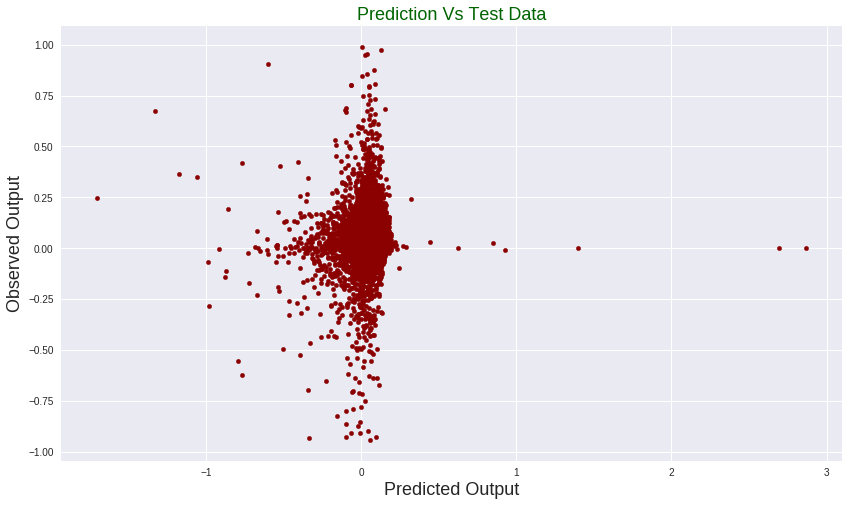

In [67]:
filtered = np.ma.masked_outside(y_test.values, -1, 1).mask
test = pd.DataFrame({"prediction": y_pred[~filtered], "observed": y_test.values[~filtered].flatten()})
test.plot(figsize = [14,8], x ="prediction", y = "observed", kind = "scatter", color = 'darkred')
plt.title("Prediction Vs Test Data", fontsize = 18, color = "darkgreen")
plt.xlabel("Predicted Output", fontsize = 18) 
plt.ylabel("Observed Output", fontsize = 18)
plt.show()

## Result of prediction
Since we are targetting the highest return, we should sort it based on `y_pred`.

First, merge the prediction dataframe with the test data:

---



In [70]:
test = pd.DataFrame(data=(X_test))
test['raise_per_day_prediction'] = y_pred
# test = test.sort_values('raise_per_day_prediction', ascending=False)
test.head()

,region_id,house_type_id,area_id,neighbourhood_id,area_sf,is_landed_property,number_of_days,start_price,end_price,raise_per_day_prediction
,,,,,,,,,,
693,0,3,83,1426,657.0,1,1992,108000.0,220000.0,0.167299
20770,0,1,123,1973,1130.0,1,1596,470000.0,660000.0,0.055433
5014,1,9,126,2914,1701.0,0,804,463000.0,620000.0,0.077823
20849,1,9,70,2235,1647.0,0,1001,200000.0,355000.0,0.121769
18399,0,1,28,2852,1087.0,1,1946,635000.0,620000.0,0.009213


Then transform it into readable table with relevant data and sort it by the estimated return.

In [75]:
prediction = pd.DataFrame(data={})

prediction['State'] = [le_r.inverse_transform(k) for k in test['region_id']]
prediction['Area'] = [le_a.inverse_transform(k) for k in test['area_id']]
prediction['Neighbourhood or Township'] = [le_n.inverse_transform(k) for k in test['neighbourhood_id']]

prediction['Property Type'] = [le_h.inverse_transform(k) for k in test['house_type_id']]
prediction['Area in sq. ft'] = test['area_sf']
prediction['Duration of Investment (days)'] = test['number_of_days']
prediction['Prediction on Price Appreciation per day(per sf)'] = test['raise_per_day_prediction']

prediction['Price Appreciation per day'] = [ ("RM%.2f" % k) for k in test['raise_per_day_prediction']*test['area_sf']]

prediction['er'] = test['raise_per_day_prediction'] * test['number_of_days'] * test['area_sf']

# roi
prediction['ROI'] = prediction['er'] / test['start_price']
prediction['actual ROI'] = (test['end_price'] - test['start_price']) / test['start|_price']

# sort by er
prediction = prediction.sort_values('er', ascending=False).reset_index()

# beautify er and drop
prediction['Estimated return'] = [ "RM{0:,.2f}".format(k) for k in prediction['er']]



prediction.drop(columns=['er', 'index'], inplace=True)


prediction.head(10)



,State,Area,Neighbourhood or Township,Property Type,Area in sq. ft,Duration of Investment (days),Prediction on Price Appreciation per day(per sf),Price Appreciation per day,ROI,actual ROI,Estimated return
0,Selangor,bandar-sri-damansara,SD Tower,Condominium/Apartment,16770.0,854.0,0.442865,RM37.82,25.215270,1.666826,"RM6,342,522.95"
1,KL,kepong,"Fortune Court, Kepong",Flat,21776.0,426.0,0.623525,RM123.81,57.841737,-0.100000,"RM5,784,173.70"
2,KL,kepong,First Residence,Condominium/Apartment,10969.0,1790.0,0.288381,RM30.37,22.444524,0.585565,"RM5,662,214.82"
3,Selangor,seri-kembangan,Taman Sungai Besi Indah,Terrace House,12002.0,1073.0,0.272807,RM110.65,9.245377,0.421184,"RM3,513,243.43"
4,Selangor,bangi,"Section 4, Bandar Baru Bangi",Terrace House,7998.0,1488.0,0.185534,RM66.09,8.120816,0.058948,"RM2,208,049.76"
5,Selangor,ulu-kelang,Taman Sri Ukay,Terrace House,7901.0,1052.0,0.170382,RM37.07,4.720634,0.264000,"RM1,416,190.20"
6,Selangor,shah-alam,Kemuning Utama,Terrace House,8062.0,921.0,0.162399,RM64.81,3.768206,0.310075,"RM1,205,825.93"
7,Selangor,kajang,Taman Kajang Utama,Flat,9332.0,449.0,0.188038,RM119.15,2.411483,0.285301,"RM787,891.70"
8,Selangor,dengkil,Harmoni Park,Semi-Detached House,3993.0,1220.0,0.126641,RM-49.61,5.364573,2.913043,"RM616,925.94"
9,Selangor,petaling-jaya,Menara Bakti,Condominium/Apartment,2433.0,1316.0,0.180094,RM62.34,7.207865,6.125000,"RM576,629.18"


## Cross Validation





In [68]:
""" CROSS VALIDATION """
kfold = KFold(n_splits=10)
modelCV = LinearRegression()
scoring = "neg_mean_squared_error"
results = cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average RMSE: %.3f" % np.sqrt(np.abs(results.mean())))

10-fold cross validation average RMSE: 1.761


# Linear Regression based on ROI

### Data Compilation

---


Reset and re-obtain the data 

In [134]:
""" IMPORT DATA """
df_KL = pd.read_csv(pwd + 'output/kl.csv', sep = ';')
df_KL["region"] = "KL"
df_Selangor = pd.read_csv(pwd + 'output/selangor.csv', sep = ';')
df_Selangor["region"] = "Selangor"
df = pd.concat([df_KL, df_Selangor])

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Drop duplicated rows or having missing values
df.dropna()
df.drop_duplicates(inplace=True)

# Calculate price per square foot (psf)
df["price_psf"] = df.price / df.area_sf

# Sort by address, area_sf and date 
df.sort_values(by=["addr", "area_sf", "date"], inplace=True, ascending=False)

# Remove rows having 1 transaction only
df = df[df.duplicated(subset=['addr', 'area_sf'], keep=False)]

print("No. of Rows (Raw data):", len(df.index))
df.head(10)

No. of Rows (Raw data): 234230


,addr,area_sf,date,house_type,price,area,neighbourhood,region,price_psf
125482,Zara Zero Lot Bunglow,3595.0,2013-05-31,Detached House,856518.0,bandar-country-homes,Saujana Rawang,Selangor,238.252573
125499,Zara Zero Lot Bunglow,3595.0,2012-07-27,Detached House,832098.0,bandar-country-homes,Saujana Rawang,Selangor,231.459805
125507,Zara Zero Lot Bunglow,3595.0,2012-03-20,Detached House,832098.0,bandar-country-homes,Saujana Rawang,Selangor,231.459805
125512,Zara Zero Lot Bunglow,3595.0,2012-02-28,Detached House,722184.0,bandar-country-homes,Saujana Rawang,Selangor,200.885675
185908,Wsl 09,1378.0,2013-07-11,Semi-Detached House,650000.0,kajang,Taman Saujana Suria,Selangor,471.698113
185915,Wsl 09,1378.0,2013-06-14,Semi-Detached House,650000.0,kajang,Taman Saujana Suria,Selangor,471.698113
185911,Wsl 02,1378.0,2013-06-28,Semi-Detached House,650000.0,kajang,Taman Saujana Suria,Selangor,471.698113
185913,Wsl 02,1378.0,2013-06-21,Semi-Detached House,650000.0,kajang,Taman Saujana Suria,Selangor,471.698113
185905,Wsd Suria Saujana,3498.0,2013-08-14,Semi-Detached House,928000.0,kajang,Taman Saujana Suria,Selangor,265.294454
185906,Wsd Suria Saujana,3498.0,2013-08-01,Semi-Detached House,928000.0,kajang,Taman Saujana Suria,Selangor,265.294454


### Simple analytics on ROI

---



In [135]:
# Get min/max date and its price accordingly
df = df.groupby(["addr", "region", "area_sf", "house_type", "area", "neighbourhood"]).agg({"date": ["first", "last", "count"], 'price': ['first', 'last']})

# Calculate average roi psf by day
df["number_of_days"] = (pd.to_datetime(df.date["first"]) - pd.to_datetime(df.date["last"])).apply(lambda x: x.days)
df.drop(df[df["number_of_days"] == 0].index, inplace=True)

df["transaction_count"] = df.date['count']
df['start_price'] = df.price['first']
df['end_price'] = df.price['last']

df["roi"] = (df["end_price"] - df['start_price']) / df["start_price"]

# Remove edge cases of ridiculous number of avg_price_psf_change by limiting
# the amount of transaction to be above 3
# df.drop(df[df["transaction_count"] < 3].index, inplace=True)

# Drop unnecessary columns
df.reset_index(inplace=True)
df.drop(["addr", "date", "price_psf", "price_psf_change"], axis=1, inplace=True, level=0)

print("No. of Rows (Processed data):", len(df.index))
# df.head(10)
df.sort_values('roi', ascending=False).head(10)

No. of Rows (Processed data): 38088


region  area_sf             house_type  \
                                                  
36904  Selangor   1098.0  Condominium/Apartment   
1550   Selangor   1604.0          Terrace House   
7427   Selangor  32701.0                   Land   
4695         KL   1432.0          Terrace House   
10102  Selangor    775.0         Low-Cost House   
4411   Selangor   1604.0          Terrace House   
15669  Selangor   1195.0          Terrace House   
9876   Selangor    484.0                   Flat   
3185   Selangor   1485.0          Terrace House   
25163  Selangor   1647.0          Terrace House   

                                    area                neighbourhood  \
                                                                        
36904                      ara-damansara           Puncak Nusa Kelana   
1550                              gombak              Taman Greenwood   
7427                             puchong      Kampung Kenangan, Bt 13   
4695   jalan-klang-lama-(old-klang-road)            Taman Tan Yew Lai   
10102                    batu-9th-cheras       Taman Koperasi Cuepacs   
4411                       petaling-jaya   Section 51A, Petaling Jaya   
15669                              kapar              Taman Sri Wangi   
9876                     batu-9th-cheras              Taman Alam Jaya   
3185                              kepong              Taman Desa Jaya   
25163          setia-alam_alam-nusantara  Anjung Sari, Alam Nusantara   

         price            number_of_days transaction_count start_price  \
         first       last                                                
36904  15000.0   580000.0             14                 2     15000.0   
1550   10000.0   345000.0            883                 3     10000.0   
7427   30000.0  1000000.0           1454                 3     30000.0   
4695    7500.0   240000.0           1508                 5      7500.0   
10102   5000.0   150000.0            884                 4      5000.0   
4411   13888.0   355000.0            934                 2     13888.0   
15669   5500.0   138000.0             72                 3      5500.0   
9876    2000.0    50000.0           1324                 2      2000.0   
3185   10000.0   232000.0            377                 2     10000.0   
25163  25000.0   548888.0           1497                10     25000.0   

       end_price        roi  
                             
36904   580000.0  37.666667  
1550    345000.0  33.500000  
7427   1000000.0  32.333333  
4695    240000.0  31.000000  
10102   150000.0  29.000000  
4411    355000.0  24.561636  
15669   138000.0  24.090909  
9876     50000.0  24.000000  
3185    232000.0  22.200000  
25163   548888.0  20.955520

In [136]:
# filtering landed/non-landed
non_landed = ['Flat', 'Condominium/Apartment', 'Hotel/Service Apartment']
df['is_landed_property'] = [1 if d in non_landed else 0 for d in df['house_type']]

# Encode categorical columns
le_r = preprocessing.LabelEncoder()
le_h = preprocessing.LabelEncoder()
le_a = preprocessing.LabelEncoder()
le_n = preprocessing.LabelEncoder()
df["region_id"] = le_r.fit_transform(df["region"])
df["house_type_id"] = le_h.fit_transform(df["house_type"])
df["area_id"] = le_a.fit_transform(df["area"])
df["neighbourhood_id"] = le_n.fit_transform(df["neighbourhood"])
df.head() # aftermath showing

region area_sf               house_type                 area  \
                                                                    
0        KL  1023.0  Hotel/Service Apartment  taman-tun-dr-ismail   
1        KL  1098.0  Hotel/Service Apartment  taman-tun-dr-ismail   
2  Selangor  1647.0            Terrace House            shah-alam   
3        KL   829.0    Condominium/Apartment           taman-desa   
4        KL   926.0    Condominium/Apartment           taman-desa   

                neighbourhood     price           number_of_days  \
                                  first      last                  
0  Glomac Residensi Damansara  925000.0  860000.0             84   
1  Glomac Residensi Damansara  920000.0  818000.0            158   
2        Seksyen 7, Shah Alam  673500.0  707100.0            140   
3       Apartment Abadi Indah  340000.0  275000.0            327   
4       Apartment Abadi Indah  350000.0  290000.0            407   

  transaction_count start_price end_price       roi is_landed_property  \
                                                                         
0                 2    925000.0  860000.0 -0.070270                  1   
1                 2    920000.0  818000.0 -0.110870                  1   
2                 4    673500.0  707100.0  0.049889                  0   
3                 2    340000.0  275000.0 -0.191176                  1   
4                 2    350000.0  290000.0 -0.171429                  1   

  region_id house_type_id area_id neighbourhood_id  
                                                    
0         0             4     124              742  
1         0             4     124              742  
2         1             9     105             1982  
3         0             1     118              121  
4         0             1     118              121

In [137]:
# shuffle data
df2 = shuffle(df)
# X_raw = df[["region_id", "house_type_id", "area_id", "neighbourhood_id", "area_sf"]]
X = df2[["region_id", "house_type_id", "area_id", "neighbourhood_id", "area_sf", "is_landed_property", "number_of_days", 'start_price']]
y = df2["roi"]

X.head(10)
# X

,region_id,house_type_id,area_id,neighbourhood_id,area_sf,is_landed_property,number_of_days,start_price
,,,,,,,,
4535,0,3,76,792,721.0,1,1685,300000.0
27977,1,1,63,126,721.0,1,1046,98000.0
18628,1,3,97,1349,818.0,1,1882,230000.0
1221,0,1,76,557,1281.0,1,1616,450000.0
37813,0,3,35,1967,1044.0,1,199,210000.0
30381,1,8,104,2068,3498.0,0,392,1980000.0
30681,1,8,31,365,3197.0,0,156,1750000.0
29650,1,9,87,1310,1539.0,0,1726,700000.0
28712,1,2,115,992,8439.0,0,205,620000.0


### Model Training and Prediction

---



In [138]:
""" LINEAR REGRESSION """
       
# Split training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

linearReg = LinearRegression()
linearReg.fit(X_train, y_train)
y_pred = linearReg.predict(X_test)
# Root mean squared error
print("Root mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)))
# Explained variance score: 1 is perfect prediction
print('R-squared score: %.2f' % r2_score(y_test, y_pred))

Root mean square error for test dataset: 0.64
Variance score: 0.02


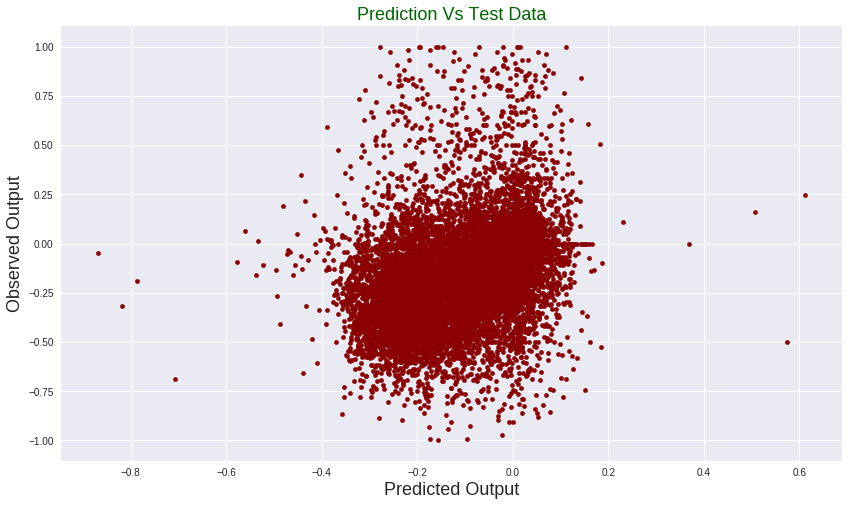

In [139]:
filtered = np.ma.masked_outside(y_test.values, -1, 1).mask
test = pd.DataFrame({"prediction": y_pred[~filtered], "observed": y_test.values[~filtered].flatten()})
test.plot(figsize = [14,8], x ="prediction", y = "observed", kind = "scatter", color = 'darkred')
plt.title("Prediction Vs Test Data", fontsize = 18, color = "darkgreen")
plt.xlabel("Predicted Output", fontsize = 18) 
plt.ylabel("Observed Output", fontsize = 18)
plt.show()

### Result

---



In [140]:
test = pd.DataFrame(data=(X_test))
test['ROI'] = y_pred
test.head()

,region_id,house_type_id,area_id,neighbourhood_id,area_sf,is_landed_property,number_of_days,start_price,ROI
,,,,,,,,,
7111,1,1,71,3375,2325.0,1,487,145000.0,-0.034876
2922,1,9,105,1932,1539.0,0,22,400000.0,0.043225
7874,1,1,126,1308,1410.0,1,1447,590000.0,-0.234302
27115,1,8,65,1879,4898.0,0,413,1428000.0,-0.073694
23064,1,9,105,1957,1765.0,0,357,500000.0,-0.020849


In [141]:
prediction = pd.DataFrame(data={})

prediction['State'] = [le_r.inverse_transform(k) for k in test['region_id']]
prediction['Area'] = [le_a.inverse_transform(k) for k in test['area_id']]
prediction['Neighbourhood or Township'] = [le_n.inverse_transform(k) for k in test['neighbourhood_id']]

prediction['Property Type'] = [le_h.inverse_transform(k) for k in test['house_type_id']]
prediction['Area in sq. ft'] = test['area_sf']
prediction['Duration of Investment (days)'] = test['number_of_days']
# roi
prediction['roi'] = test['ROI']

# sort by roi, then beautify
prediction = prediction.sort_values('roi', ascending=False).reset_index()
prediction['ROI'] = ['%.2f%%' % (k*100) for k in prediction['roi']]

prediction.drop(columns=['roi','index'], inplace=True)


prediction.head(10)

,State,Area,Neighbourhood or Township,Property Type,Area in sq. ft,Duration of Investment (days),ROI
0,Selangor,sungai-buloh,Bandar Baru Sungai Buloh,Terrace House,4252.0,28.0,23.05%
1,Selangor,cheras,Pangsapuri Meranti,Flat,452.0,319.0,18.21%
2,Selangor,shah-alam,"Section 18, Shah Alam",Flat,1604.0,71.0,17.06%
3,KL,setapak,Taman Sri Rampai,Terrace House,4241.0,351.0,16.38%
4,Selangor,rawang,Bandar Tasik Puteri,Semi-Detached House,21776.0,400.0,16.17%
5,Selangor,hulu-selangor,Seri Lili Apartment,Flat,5091.0,320.0,15.88%
6,Selangor,shah-alam,"Taman Alam Megah, Seksyen 28",Terrace House,1432.0,133.0,15.70%
7,Selangor,hulu-selangor,Bukit Sentosa,Terrace House,2562.0,41.0,15.07%
8,Selangor,kota-kemuning,Kota Kemuning,Terrace House,26705.0,559.0,14.44%
9,Selangor,shah-alam,Sri Damai,Town House,10689.0,30.0,14.43%


### Cross Validation

---



In [142]:
""" CROSS VALIDATION """
kfold = KFold(n_splits=10)
modelCV = LinearRegression()
scoring = "neg_mean_squared_error"
results = cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average RMSE: %.3f" % np.sqrt(np.abs(results.mean())))

10-fold cross validation average RMSE: 0.700
